# Text Mining 2024 Project
### Group 07 | Francisco Perestrello | 20241560

## Import Libraries

In [ ]:
#!pip install sklearn
#!pip install nltk
#!pip install tensorflow
#!pip install transformers
#!pip install tensorflow
#!pip install Keras-Preprocessing
#!pip install gensim
#!pip install wordcloud
#!pip install collections

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import gensim.downloader
import tensorflow as tf
import tensorflow.keras as keras
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, LSTM, Dense, TimeDistributed, Bidirectional, Masking
from keras import layers
from keras import backend as K
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import bigrams
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from transformers import pipeline
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm

## Data Import

In [2]:
df_train = pd.read_csv('Project Data/train.csv')
df_train.head(5)

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


## 1. Data Exploration

### Dependent Feature

In [3]:
df_train['label'].unique()

array([0, 1, 2], dtype=int64)

In [4]:
df_train['label'].describe()

count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

In [5]:
df_train['label'].isna().sum()

0

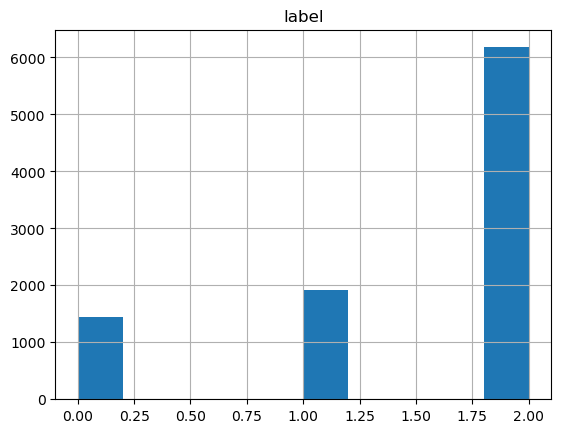

In [6]:
df_train.hist(['label'])
plt.show()

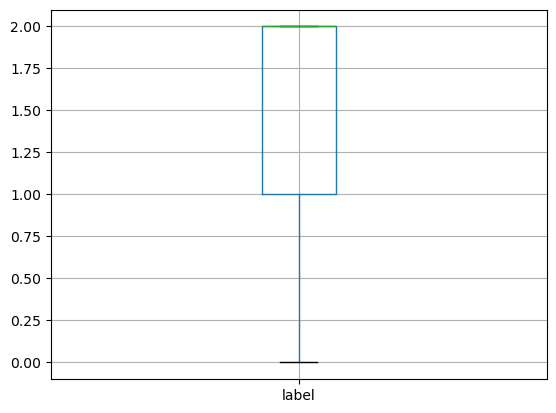

In [7]:
df_train.boxplot(['label'])
plt.show()

### Independent Feature

In [8]:
df_train['text'].isna().sum()

0

In [9]:
df_train['word_count'] = df_train['text'].apply(lambda x: len(word_tokenize(x)))
df_train.head(5)

,text,label,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,0,13
1,$CCL $RCL - Nomura points to bookings weakness...,0,18
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,18
3,$ESS: BTIG Research cuts to Neutral https://t....,0,11
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,13


In [10]:
df_train['word_count'].describe()

count    9543.000000
mean       15.321073
std         6.429211
min         1.000000
25%        10.000000
50%        14.000000
75%        20.000000
max        49.000000
Name: word_count, dtype: float64

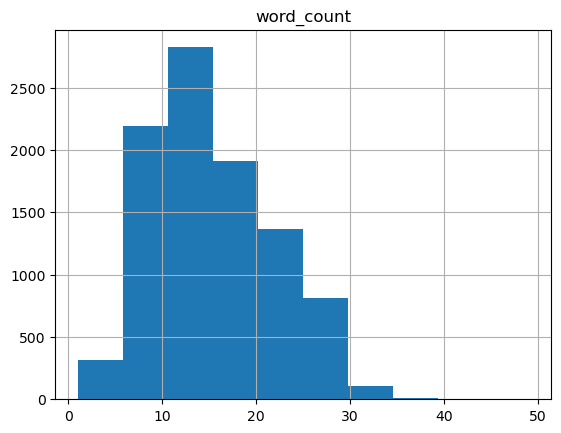

In [11]:
df_train.hist(['word_count'])
plt.show()

In [12]:
# Calculate word frequency
all_words = word_tokenize(' '.join(df_train['text']))

freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:15]

:        7355
https    5093
$        3310
,        2532
to       2338
#        2182
the      1828
of       1467
-        1394
in       1371
's       1224
.        1175
on       1141
for      1038
a         976
Name: count, dtype: int64

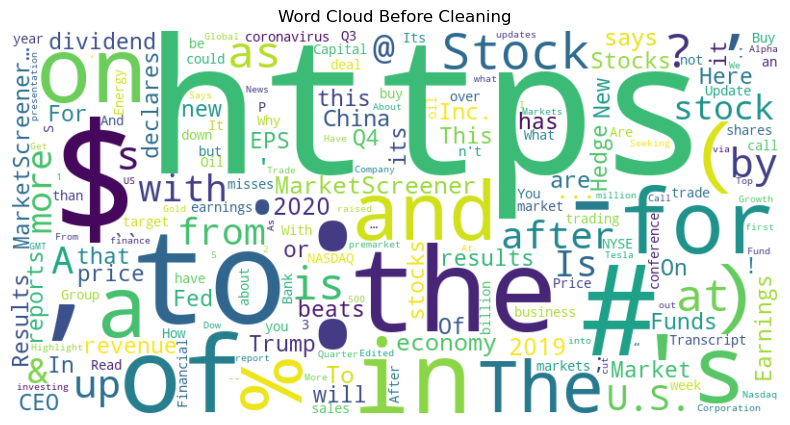

In [13]:
# Generate the word cloud 
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Before Cleaning')
plt.show()

## 2. Corpus Split

In [14]:
X_train, X_val, y_train, y_val = train_test_split(df_train['text'], df_train['label'], test_size=0.1, random_state=7)

len(X_train), len(X_val), len(y_train), len(y_val)

(8588, 955, 8588, 955)

## 3. Data Preprocessing

In [15]:
def clean(text_list, lower=True, nums_punct=True, stop_words=True, regular_expressions=True, lemmatize=True, stem=False):
   
    stop = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
    stemmer = SnowballStemmer('english')
    
    updates = []
    
    for j in tqdm(text_list):
        
        text = j
        
        #1 Lowercase Text
        if lower:
            text = text.lower()

        #2 Substitute Regular Expressions
        if regular_expressions:
            text = re.sub(r'https?://\S+|www\.\S+', 'website', text)
        
        #3 Remove Numerical Data and Punctuation
        if nums_punct:
            text = re.sub("[^a-zA-Z]"," ", text ) # Replaces any character except those alphabetically between a and z, lower case or upper case, with a blank space
        
        #4 Remove Stopwords
        if stop_words:
            text = " ".join([word for word in text.split() if word not in stop])
        
        #5 Lemmatize - EXTRA WORK
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())

        #6 Stemming - EXTRA WORK
        if stem:
            text = " ".join(stemmer.stem(word) for word in text.split())
            
        updates.append(text)
        
    return pd.Series(updates)

In [16]:
X_train_clean = clean(X_train)
X_val_clean = clean(X_val)

100%|█████████████████████████████████████████████████████████████████████████████| 955/955 [00:00<00:00, 13738.04it/s]


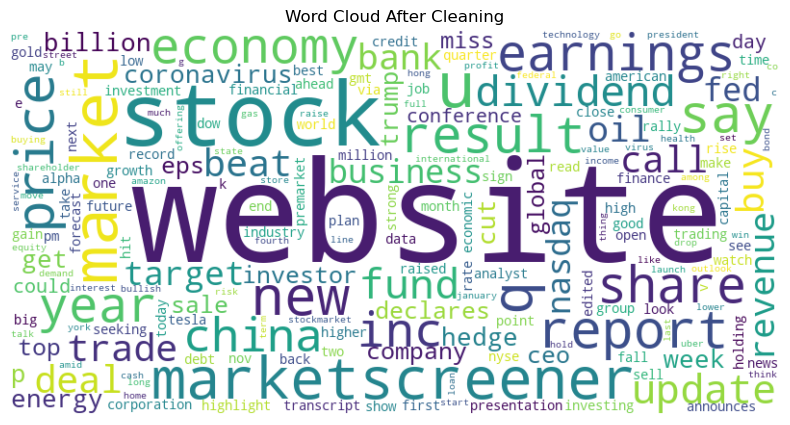

In [17]:
# Calculate word frequencies after cleaning the data
all_words = word_tokenize(' '.join(X_train_clean))
freq = pd.Series(all_words).value_counts()

# Generate the word cloud 
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud After Cleaning')
plt.show()

## 4. Feature Engineering

### Bag of Words (BoW)

In [18]:
# Initialize the Model
bow = CountVectorizer(binary=True)

# Create the BoW and fill the vectors for each tweet
X_train_bow = bow.fit_transform(X_train_clean).toarray()
X_val_bow = bow.transform(X_val_clean).toarray()

y_train_bow = np.array(y_train)
y_val_bow = np.array(y_val)

In [19]:
X_train_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [20]:
np.shape(X_train_bow)

(8588, 12764)

### TF-IDF

In [21]:
# Initialize the model
tfidf = TfidfVectorizer(max_df=0.8, ngram_range=(1,2))

# Fit the model for both training and validation data
X_train_tfidf = tfidf.fit_transform(X_train_clean).toarray()
X_val_tfidf = tfidf.transform(X_val_clean).toarray()

y_train_tfidf = np.array(y_train)
y_val_tfidf = np.array(y_val)

In [22]:
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
np.shape(X_train_tfidf)

(8588, 60711)

### Word2Vec (W2V)

In [24]:
# Load the model
w2v = gensim.downloader.load('glove-twitter-25') # could play around with number of embeddings (25 - 50 - 100 - 200)

# function to get embeddings for each word based on w2v list
def corpus2vec(corpus):
    corpus_vec = []
    for document in tqdm(corpus):
        #get word vectors for each document
        doc_vectors = []
        for word in document.split():
            if word in w2v.index_to_key:
                doc_vectors.append(w2v.word_vec(word))         
        corpus_vec.append(doc_vectors)
    return corpus_vec

# get the embeddings
X_train_w2v = corpus2vec(X_train_clean)
X_val_w2v = corpus2vec(X_val_clean)

# these will be used for the more basic models
y_train_w2v = np.array(y_train)
y_val_w2v = np.array(y_val)

  0%|                                                                                         | 0/8588 [00:00<?, ?it/s]C:\Users\20241560\AppData\Local\Temp\ipykernel_10964\848990036.py:12: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  doc_vectors.append(w2v.word_vec(word))
100%|████████████████████████████████████████████████████████████████████████████████| 955/955 [00:17<00:00, 54.22it/s]


In [25]:
# Pad Sequencing
train_w2v_len = []
for i in X_train_w2v:
    train_w2v_len.append(len(i))

#make all sentences the same size
X_train_w2v_pad = pad_sequences(maxlen=max(train_w2v_len), sequences=X_train_w2v, padding="post", dtype='float64')
X_val_w2v_pad = pad_sequences(maxlen=max(train_w2v_len), sequences=X_val_w2v, padding="post", dtype='float64')

#turn input into a tensor (required for advanced models)
X_train_w2v_pad = tf.convert_to_tensor(X_train_w2v_pad, dtype='float32')
X_val_w2v_pad = tf.convert_to_tensor(X_val_w2v_pad, dtype='float32')

#turn output into one hot encoded matrix for advanced models
y_train_w2v_pad = tf.one_hot(y_train, depth=3)
y_val_w2v_pad = tf.one_hot(y_val, depth=3)

In [26]:
np.shape(X_train_w2v_pad)

TensorShape([8588, 24, 25])

In [27]:
# Required for more basic models
X_train_w2v_pad_2d = np.mean(X_train_w2v_pad, axis=1)
X_val_w2v_pad_2d = np.mean(X_val_w2v_pad, axis=1)
np.shape(X_train_w2v_pad_2d)

(8588, 25)

### Extra Work

### Pre-Trained Language Models

In [29]:
# initialize the model
pipe = pipeline("feature-extraction", model="cardiffnlp/twitter-xlm-roberta-base", tokenizer="cardiffnlp/twitter-xlm-roberta-base")

def get_embeddings(text):
    # Create embeddings for each token
    embeddings = pipe(text)[0]  # Output shape is (num_tokens, embedding_dim)
    return embeddings

# Apply to both train and validation sets
X_train_ptlm = X_train_clean.apply(get_embeddings).tolist()
X_val_ptlm = X_val_clean.apply(get_embeddings).tolist()

# Required for more basic models
y_train_ptlm = np.array(y_train)
y_val_ptlm = np.array(y_val)

All model checkpoint layers were used when initializing TFXLMRobertaModel.

All the layers of TFXLMRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.
Device set to use 0


In [30]:
# Pad sequencing
train_ptlm_len = []
for i in X_train_ptlm:
    train_ptlm_len.append(len(i))

#make all sentences the same size
X_train_ptlm_pad = pad_sequences(maxlen=max(train_ptlm_len), sequences=X_train_ptlm, padding="post", dtype='float64')
X_val_ptlm_pad = pad_sequences(maxlen=max(train_ptlm_len), sequences=X_val_ptlm, padding="post", dtype='float64')

#turn input into a tensor (required for advanced models)
X_train_ptlm_pad = tf.convert_to_tensor(X_train_ptlm_pad, dtype='float32')
X_val_ptlm_pad = tf.convert_to_tensor(X_val_ptlm_pad, dtype='float32')

#turn output into one hot encoded matrix for advanced models
y_train_ptlm_pad = tf.one_hot(y_train, depth=3)
y_val_ptlm_pad = tf.one_hot(y_val, depth=3)

In [31]:
np.shape(X_train_ptlm_pad)

TensorShape([8588, 48, 768])

In [32]:
# Required for more basic models
X_train_ptlm_pad_2d = np.mean(X_train_ptlm_pad, axis=1)
X_val_ptlm_pad_2d = np.mean(X_val_ptlm_pad, axis=1)
np.shape(X_train_ptlm_pad_2d)

(8588, 768)

### Point-wise Mutual Information (PMI)

In [34]:
# Step 1: Tokenize the Corpus
corpus_train = [word_tokenize(doc) for doc in X_train_clean]
corpus_val = [word_tokenize(doc) for doc in X_val_clean]

# Step 2: Find all bigrams in the Training set
bigram_finder = BigramCollocationFinder.from_documents(corpus_train)

# Step 3: Compute PMI for all bigrams from BigramAssocMeasures
all_pmi_scores = {bigram: bigram_finder.score_ngram(BigramAssocMeasures.pmi, bigram[0], bigram[1]) for bigram in bigram_finder.ngram_fd} #ngram_fd -> ngram frequency distribution

# Create a list of all bigrams considered
bigram_vocab = list(all_pmi_scores.keys())

# Function to create a feature vector for each document using the PMI scores
def create_pmi_feature_vector(doc, bigram_vocab, pmi_scores):
    # Tokenize the document and get bigrams
    doc_bigrams = list(bigrams(doc))
    feature_vector = []
    for bigram in bigram_vocab:
        # If the bigram exists in the document, append its PMI score; otherwise, 0
        if bigram in doc_bigrams:
            feature_vector.append(pmi_scores[bigram])
        else:
            feature_vector.append(0)
    return feature_vector

# Fit the data
X_train_pmi = [create_pmi_feature_vector(doc, bigram_vocab, all_pmi_scores) for doc in corpus_train]
X_val_pmi = [create_pmi_feature_vector(doc, bigram_vocab, all_pmi_scores) for doc in corpus_val]

y_train_pmi = np.array(y_train)
y_val_pmi = np.array(y_val)

In [35]:
bigram_finder.ngram_fd

FreqDist({('website', 'website'): 475, ('marketscreener', 'website'): 435, ('stock', 'marketscreener'): 288, ('q', 'result'): 192, ('hedge', 'fund'): 165, ('declares', 'dividend'): 137, ('price', 'target'): 130, ('stock', 'market'): 130, ('economy', 'marketscreener'): 125, ('report', 'q'): 121, ...})

In [41]:
np.array(X_train_pmi)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  4.34475636,
        12.89165082, 16.21357891]])

In [36]:
np.shape(X_train_pmi)

(8588, 48742)

In [37]:
#scale
scaler = StandardScaler()
X_train_pmi = scaler.fit_transform(X_train_pmi)
X_val_pmi = scaler.transform(X_val_pmi)

## 5. Classification Models

### K-Nearest Neighbors (KNN)

In [39]:
# Initialize the model
knn = KNeighborsClassifier(n_neighbors = 10, metric = 'cosine', weights = 'distance')

# BoW
knn.fit(X_train_bow, y_train_bow)
y_val_pred_bow_knn = knn.predict(X_val_bow)

# TF-IDF
knn.fit(X_train_tfidf, y_train_tfidf) 
y_val_pred_tfidf_knn = knn.predict(X_val_tfidf)

# W2V - 2D
knn.fit(X_train_w2v_pad_2d, y_train_w2v)
y_val_pred_w2v_knn = knn.predict(X_val_w2v_pad_2d)

# PTLM - 2D
knn.fit(X_train_ptlm_pad_2d, y_train_ptlm)
y_val_pred_ptlm_knn = knn.predict(X_val_ptlm_pad_2d)

# PMI
knn.fit(X_train_pmi, y_train_pmi)
y_val_pred_pmi_knn = knn.predict(X_val_pmi)

### Logistic Regression

In [40]:
# Initialize the model
lr = LogisticRegression(random_state=7)

# BoW
lr.fit(X_train_bow, y_train_bow)
y_val_pred_bow_lr = lr.predict(X_val_bow)

# TF-IDF
lr.fit(X_train_tfidf, y_train_tfidf) 
y_val_pred_tfidf_lr = lr.predict(X_val_tfidf)

# W2V - 2D
lr.fit(X_train_w2v_pad_2d, y_train_w2v)
y_val_pred_w2v_lr = lr.predict(X_val_w2v_pad_2d)

# PTLM - 2D
lr.fit(X_train_ptlm_pad_2d, y_train_ptlm)
y_val_pred_ptlm_lr = lr.predict(X_val_ptlm_pad_2d)

# PMI
lr.fit(X_train_pmi, y_train_pmi)
y_val_pred_pmi_lr = lr.predict(X_val_pmi)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

### Naive Bayes

In [43]:
# Initialize the model
nb = GaussianNB()

# BoW
nb.fit(X_train_bow, y_train_bow)
y_val_pred_bow_nb = nb.predict(X_val_bow)

# TF-IDF
nb.fit(X_train_tfidf, y_train_tfidf) 
y_val_pred_tfidf_nb = nb.predict(X_val_tfidf)

# W2V - 2D
nb.fit(X_train_w2v_pad_2d, y_train_w2v)
y_val_pred_w2v_nb = nb.predict(X_val_w2v_pad_2d)

# PTLM - 2D
nb.fit(X_train_ptlm_pad_2d, y_train_ptlm)
y_val_pred_ptlm_nb = nb.predict(X_val_ptlm_pad_2d)

# PMI
nb.fit(X_train_pmi, y_train_pmi)
y_val_pred_pmi_nb = nb.predict(X_val_pmi)

### Multi-Layer Perceptron (MLP)

In [54]:
# Initialize the model
mlp = MLPClassifier(solver='adam', hidden_layer_sizes=(2,2), activation='relu', random_state=7)

# BoW
mlp.fit(X_train_bow, y_train_bow)
y_val_pred_bow_mlp = mlp.predict(X_val_bow)

# TF-IDF
mlp.fit(X_train_tfidf, y_train_tfidf) 
y_val_pred_tfidf_mlp = mlp.predict(X_val_tfidf)

# W2V - 2D
mlp.fit(X_train_w2v_pad_2d, y_train_w2v)
y_val_pred_w2v_mlp = mlp.predict(X_val_w2v_pad_2d)

# PTLM - 2D
mlp.fit(X_train_ptlm_pad_2d, y_train_ptlm)
y_val_pred_ptlm_mlp = mlp.predict(X_val_ptlm_pad_2d)

# PMI
mlp.fit(X_train_pmi, y_train_pmi)
y_val_pred_pmi_mlp = mlp.predict(X_val_pmi)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Extra Work

### Pre-Trained Large Language Models (LLMs)

In [75]:
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

model = pipeline("text-classification", model=MODEL, tokenizer=MODEL)

# Roberta Base Sentiment works as follows. Labels: 0 -> Negative; 1 -> Neutral; 2 -> Positive
# Our problem is 0 -> Bearish, 1 -> Bullish, 2 -> Neutral

def predict_llm(X):
    y_pred = []
    for y in tqdm(X):
        pred = model(y)
        if pred[0]['label']=='LABEL_0':
            pred_label=0
        elif pred[0]['label']=='LABEL_1':
            pred_label=2
        elif pred[0]['label']=='LABEL_2':
            pred_label=1
        y_pred.append(pred_label)
    return y_pred

# There is no use for word embeddings with pre-trained LLMs
y_val_pred_llm = predict_llm(X_val_clean)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.
Device set to use 0
100%|████████████████████████████████████████████████████████████████████████████████| 955/955 [04:47<00:00,  3.32it/s]


### Long Short Term Memory (LSTM)

In [56]:
# Initialize fixed random weights
tf.random.set_seed(7)

emb_size = 25

'''model input in the shape(number of words per doc, word embedding size)'''
input_ = Input(shape=(max(train_w2v_len), emb_size))
 
'''mask layer to avoid model from considering padding vectors'''
mask_layer = Masking(mask_value=0)
mask = mask_layer(input_)

'''BiLSTM layer'''

lstm = Bidirectional(LSTM(units=16))(mask)

'''activation layer'''
act = Dense(3, activation='softmax')(lstm)

'''model input and output'''
model_w2v = Model(input_, act)

'''model loss function and evaluation metrics'''
model_w2v.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_w2v.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 24, 25)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 24, 25)            │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking (Masking)             │ (None, 24, 25)            │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any (Any)                     │ (None, 24)                │               0 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 32)                │           5,376 │ masking[0][0], any[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 3)                 │              99 │ bidirectional[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 5,475 (21.39 KB)

 Trainable params: 5,475 (21.39 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
history_w2v = model_w2v.fit(X_train_w2v_pad, y_train_w2v_pad, batch_size=16, epochs=25, verbose=0, validation_split=0.20)
y_val_pred_w2v_lstm = model_w2v.predict(X_val_w2v_pad)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [58]:
K.clear_session()  # Clear the session to reset the state

In [61]:
# Initialize the same random weights
tf.random.set_seed(7)

emb_size = 768 #twitter-xlm-roberta-base embedding size

'''model input in the shape(number of words per doc, word embedding size)'''
input_ = Input(shape=(max(train_ptlm_len), emb_size)) 
 
'''mask layer to avoid model from considering padding vectors'''
mask_layer = Masking(mask_value=0)
mask = mask_layer(input_)

'''BiLSTM layer'''

lstm = Bidirectional(LSTM(units=16))(mask)

'''activation layer'''
act = Dense(3, activation='softmax')(lstm)

'''model input and output'''
model_ptlm = Model(input_, act)

'''model loss function and evaluation metrics'''
model_ptlm.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_ptlm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 48, 768)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal (NotEqual)          │ (None, 48, 768)           │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ masking (Masking)             │ (None, 48, 768)           │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ any (Any)                     │ (None, 48)                │               0 │ not_equal[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 32)                │         100,480 │ masking[0][0], any[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 3)                 │              99 │ bidirectional[0][0]        │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 100,579 (392.89 KB)

 Trainable params: 100,579 (392.89 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
history_ptlm = model_ptlm.fit(X_train_ptlm_pad, y_train_ptlm_pad, batch_size=16, epochs=25, verbose=0, validation_split=0.20)
y_val_pred_ptlm_lstm = model_ptlm.predict(X_val_ptlm_pad)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


## 5. Evaluation

## K-Nearest Neighbours

In [63]:
labels = {"Bearish": 0, "Bullish": 1, "Neutral": 2}

# BoW
print('BoW')

# Classification Report
print(classification_report(y_val_bow, y_val_pred_bow_knn, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_bow, y_val_pred_bow_knn))


# TFIDF
print('\nTFIDF')

# Classification Report
print(classification_report(y_val_tfidf, y_val_pred_tfidf_knn, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_tfidf, y_val_pred_tfidf_knn))


# W2V
print('\nW2V')

# Classification Report
print(classification_report(y_val_w2v, y_val_pred_w2v_knn, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_w2v, y_val_pred_w2v_knn))


# PTLM
print('\nPTLM')

# Classification Report
print(classification_report(y_val_ptlm, y_val_pred_ptlm_knn, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_ptlm, y_val_pred_ptlm_knn))


# PMI
print('\nPMI')

# Classification Report
print(classification_report(y_val_pmi, y_val_pred_pmi_knn, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_pmi, y_val_pred_pmi_knn))

BoW
              precision    recall  f1-score   support

     Bearish       0.73      0.34      0.47       140
     Bullish       0.60      0.59      0.60       176
     Neutral       0.82      0.92      0.87       639

    accuracy                           0.78       955
   macro avg       0.72      0.62      0.65       955
weighted avg       0.77      0.78      0.76       955

[[ 48  28  64]
 [ 10 104  62]
 [  8  40 591]]

TFIDF
              precision    recall  f1-score   support

     Bearish       0.68      0.39      0.50       140
     Bullish       0.63      0.58      0.60       176
     Neutral       0.83      0.92      0.87       639

    accuracy                           0.78       955
   macro avg       0.71      0.63      0.66       955
weighted avg       0.77      0.78      0.77       955

[[ 55  24  61]
 [ 11 102  63]
 [ 15  36 588]]

W2V
              precision    recall  f1-score   support

     Bearish       0.48      0.22      0.30       140
     Bullish       0.

## Logistic Regression

In [64]:
# BoW
print('BoW')

# Classification Report
print(classification_report(y_val_bow, y_val_pred_bow_lr, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_bow, y_val_pred_bow_lr))


# TFIDF
print('\nTFIDF')

# Classification Report
print(classification_report(y_val_tfidf, y_val_pred_tfidf_lr, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_tfidf, y_val_pred_tfidf_lr))


# W2V
print('\nW2V')

# Classification Report
print(classification_report(y_val_w2v, y_val_pred_w2v_lr, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_w2v, y_val_pred_w2v_lr))


# PTLM
print('\nPTLM')

# Classification Report
print(classification_report(y_val_ptlm, y_val_pred_ptlm_lr, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_ptlm, y_val_pred_ptlm_lr))


# PMI
print('\nPMI')

# Classification Report
print(classification_report(y_val_pmi, y_val_pred_pmi_lr, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_pmi, y_val_pred_pmi_lr))

BoW
              precision    recall  f1-score   support

     Bearish       0.74      0.53      0.62       140
     Bullish       0.64      0.64      0.64       176
     Neutral       0.85      0.90      0.87       639

    accuracy                           0.80       955
   macro avg       0.74      0.69      0.71       955
weighted avg       0.79      0.80      0.79       955

[[ 74  15  51]
 [ 10 112  54]
 [ 16  47 576]]

TFIDF
              precision    recall  f1-score   support

     Bearish       0.77      0.41      0.54       140
     Bullish       0.71      0.54      0.61       176
     Neutral       0.81      0.94      0.87       639

    accuracy                           0.79       955
   macro avg       0.76      0.63      0.67       955
weighted avg       0.78      0.79      0.77       955

[[ 58  13  69]
 [  6  95  75]
 [ 11  26 602]]

W2V
              precision    recall  f1-score   support

     Bearish       0.27      0.04      0.07       140
     Bullish       0.

## Naive Bayes

In [69]:
# BoW
print('BoW')

# Classification Report
print(classification_report(y_val_bow, y_val_pred_bow_nb, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_bow, y_val_pred_bow_nb))


# TFIDF
print('\nTFIDF')

# Classification Report
print(classification_report(y_val_tfidf, y_val_pred_tfidf_nb, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_tfidf, y_val_pred_tfidf_nb))


# W2V
print('\nW2V')

# Classification Report
print(classification_report(y_val_w2v, y_val_pred_w2v_nb, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_w2v, y_val_pred_w2v_nb))


# PTLM
print('\nPTLM')

# Classification Report
print(classification_report(y_val_ptlm, y_val_pred_ptlm_nb, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_ptlm, y_val_pred_ptlm_nb))


# PMI
print('\nPMI')

# Classification Report
print(classification_report(y_val_pmi, y_val_pred_pmi_nb, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_pmi, y_val_pred_pmi_nb))

BoW
              precision    recall  f1-score   support

     Bearish       0.28      0.59      0.38       140
     Bullish       0.40      0.41      0.40       176
     Neutral       0.84      0.64      0.72       639

    accuracy                           0.59       955
   macro avg       0.51      0.54      0.50       955
weighted avg       0.68      0.59      0.62       955

[[ 82  21  37]
 [ 64  72  40]
 [145  87 407]]

TFIDF
              precision    recall  f1-score   support

     Bearish       0.45      0.52      0.48       140
     Bullish       0.53      0.53      0.53       176
     Neutral       0.83      0.80      0.81       639

    accuracy                           0.71       955
   macro avg       0.60      0.62      0.61       955
weighted avg       0.72      0.71      0.71       955

[[ 73  17  50]
 [ 27  93  56]
 [ 64  66 509]]

W2V
              precision    recall  f1-score   support

     Bearish       0.30      0.15      0.20       140
     Bullish       0.

## Multi-Layer Perceptron

In [66]:
# BoW
print('BoW')

# Classification Report
print(classification_report(y_val_bow, y_val_pred_bow_mlp, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_bow, y_val_pred_bow_mlp))


# TFIDF
print('\nTFIDF')

# Classification Report
print(classification_report(y_val_tfidf, y_val_pred_tfidf_mlp, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_tfidf, y_val_pred_tfidf_mlp))


# W2V
print('\nW2V')

# Classification Report
print(classification_report(y_val_w2v, y_val_pred_w2v_mlp, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_w2v, y_val_pred_w2v_mlp))


# PTLM
print('\nPTLM')

# Classification Report
print(classification_report(y_val_ptlm, y_val_pred_ptlm_mlp, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_ptlm, y_val_pred_ptlm_mlp))


# PMI
print('\nPMI')

# Classification Report
print(classification_report(y_val_pmi, y_val_pred_pmi_mlp, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_pmi, y_val_pred_pmi_mlp))

BoW
              precision    recall  f1-score   support

     Bearish       0.54      0.38      0.44       140
     Bullish       0.47      0.56      0.51       176
     Neutral       0.82      0.83      0.83       639

    accuracy                           0.72       955
   macro avg       0.61      0.59      0.59       955
weighted avg       0.72      0.72      0.71       955

[[ 53  28  59]
 [ 22  98  56]
 [ 24  83 532]]

TFIDF
              precision    recall  f1-score   support

     Bearish       0.31      0.67      0.42       140
     Bullish       0.72      0.52      0.61       176
     Neutral       0.90      0.73      0.81       639

    accuracy                           0.68       955
   macro avg       0.64      0.64      0.61       955
weighted avg       0.78      0.68      0.71       955

[[ 94  17  29]
 [ 60  92  24]
 [153  18 468]]

W2V
              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00       140
     Bullish       0.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Pre-trained Large Language Models

In [76]:
# Classification Report
print(classification_report(np.array(y_val), y_val_pred_llm, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(np.array(y_val), y_val_pred_llm))

              precision    recall  f1-score   support

     Bearish       0.48      0.29      0.36       140
     Bullish       0.48      0.23      0.31       176
     Neutral       0.70      0.86      0.78       639

    accuracy                           0.66       955
   macro avg       0.55      0.46      0.48       955
weighted avg       0.63      0.66      0.63       955

[[ 41   0  99]
 [  3  41 132]
 [ 42  45 552]]


## Long Short Term Memory

In [80]:
# W2V
print('LSTM - W2V')

# Convert to 1d array
y_pred_w2v_lstm = []
for doc in y_val_pred_w2v_lstm:
    y_pred_w2v_lstm.append(np.argmax(doc, axis=None, out=None))

# Classification Report
print(classification_report(y_val_w2v, y_pred_w2v_lstm, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_w2v, y_pred_w2v_lstm))


# PTLM
print('\nLSTM - PTLM')

# Convert to 1d array
y_pred_ptlm_lstm = []
for doc in y_val_pred_ptlm_lstm:
    y_pred_ptlm_lstm.append(np.argmax(doc, axis=None, out=None))

# Classification Report
print(classification_report(y_val_ptlm, y_pred_ptlm_lstm, target_names = labels.keys()))

# Confusion Matrix
print(confusion_matrix(y_val_ptlm, y_pred_ptlm_lstm))

LSTM - W2V
              precision    recall  f1-score   support

     Bearish       0.36      0.50      0.42       140
     Bullish       0.53      0.47      0.50       176
     Neutral       0.84      0.79      0.82       639

    accuracy                           0.69       955
   macro avg       0.58      0.59      0.58       955
weighted avg       0.71      0.69      0.70       955

[[ 70  28  42]
 [ 39  82  55]
 [ 86  45 508]]

LSTM - PTLM
              precision    recall  f1-score   support

     Bearish       0.51      0.50      0.51       140
     Bullish       0.55      0.59      0.57       176
     Neutral       0.85      0.83      0.84       639

    accuracy                           0.74       955
   macro avg       0.64      0.64      0.64       955
weighted avg       0.74      0.74      0.74       955

[[ 70  27  43]
 [ 18 104  54]
 [ 48  58 533]]


### Conclusion

Through the weighted average f1 scores, the best model comes out as the BoW embedding method combined with the Logistic Regression Classification Model

C:\Users\20241560\AppData\Local\Temp\ipykernel_10964\2516694738.py:40: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


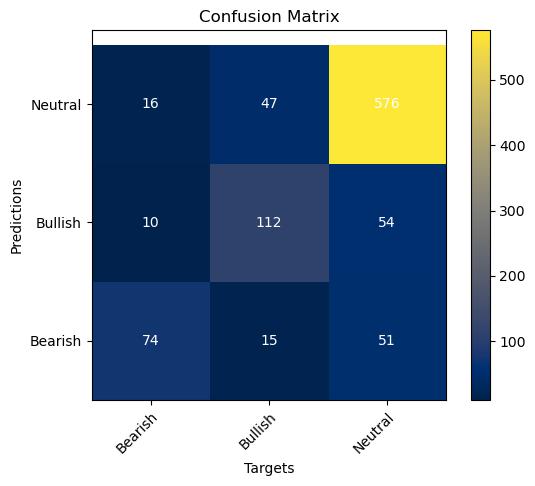

In [105]:
# Plotting the confusion matrix of the best model
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

plot_cm(confusion_matrix(y_val_bow, y_val_pred_bow_lr), labels.keys())

### Further Research

Further search could be conducted to find the optimized hyper parameters for models where we can control them, using Grid Search, making more use of our validation split

Below is how one would do it, but unfortunately I was unable to run it because of computer limitations with the computer I'm running the project in

In [ ]:
# For KNN
parameter_space_knn = {
    'n_neighbors': [10, 25, 50],
    'metric': ['euclidean','manhattan','cosine']
}

model = KNeighborsClassifier(weights = 'distance')
clf = GridSearchCV(model, parameter_space_knn, scoring='f1_weighted', verbose=1) 
clf.fit(X_train_tfidf, y_train_tfidf) # Using the best performing embedding method in KNN
final_model = clf.best_estimator_ # Returning the best parameters
print("Best Parameters:", clf.best_params_)

In [ ]:
# For MLP
parameter_space_mlp = {
    'hidden_layer_sizes': [(50,50,50), (100,)],
    'activation': ['logistic','tanh','relu'],
    'solver': ['sgd','adam'],
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

model = MLPClassifier(random_state=7)
clf = GridSearchCV(model, parameter_space_mlp, scoring='f1_weighted', verbose=1)
clf.fit(X_train_ptlm_pad_2d, y_train_ptlm) # Using one of the best performing embedding methods in MLP
final_model = clf.best_estimator_ # Returning the best parameters
print("Best Parameters:", clf.best_params_)

## Applying to the test data

In [91]:
# Load the data
X_test = pd.read_csv('Project Data/test.csv')

# Clean the data
X_test_clean = clean(X_test['text'])

# Engineer the inputs
X_test_bow = bow.transform(X_test_clean).toarray()

# Re-fitting the best model (because the last time the logistic regression was fit was to the PMI data)
lr.fit(X_train_bow, y_train_bow)

# Predict the labels
y_test_pred_bow_lr = lr.predict(X_test_bow)

# Prepare output
output_df = pd.DataFrame({
    'ID': X_test['id'],
    'Predicted_Label': y_test_pred_bow_lr
})

# Save the DataFrame to a CSV file
output_df.to_csv('predicted_labels.csv', index=False)

100%|███████████████████████████████████████████████████████████████████████████| 2388/2388 [00:00<00:00, 13657.74it/s]
